# Imports

In [81]:
import pandas as pd
from pathlib import Path
import os
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
import seaborn as sns  # Opcional, para estilização
from sklearn.metrics import explained_variance_score

# Obtenção dos dados

In [82]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Implementação

In [71]:
def train_model(X_scaled, Y_scaled):
    max_lv = 10
    lvs = []
    k=1
    loo = LeaveOneOut()
    
    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pls_model = PLSRegression(n_components=lv, max_iter=500)

        # Calibração do modelo
        pls_model.fit(X_scaled, Y_scaled)
        predictions_train = pls_model.predict(X_scaled)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        if Y_scaled.ndim == 1:
            Y_scaled = Y_scaled.reshape(-1, 1)
        if predictions_train.ndim == 1:
            predictions_train = predictions_train.reshape(-1, 1)

        correlation_cal = np.corrcoef(Y_scaled[:, 0], predictions_train[:, 0])[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train.flatten()

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(pls_model, X_scaled, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        if predictions_cv.ndim == 1:
            predictions_cv = predictions_cv.reshape(-1, 1)

        correlation_cv = np.corrcoef(Y_scaled[:, 0], predictions_cv[:, 0])[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv.flatten()
    
               
    #print(results)
    
    for j in range(1, max_lv):
        if j + 1 <= max_lv:
            rmsecv_j = validation.loc[j + 1, 'rpearson_cv']
            rmsecv_j_plus_1 = validation.loc[j, 'rpearson_cv']
            aux = rmsecv_j / rmsecv_j_plus_1
            
            if aux > 1 and ((aux - 1) * 100 >= 2):
                lvs.append(j + 1)
                k += 1
    
    if len(lvs) == 0:
        lvs.append(1)
    
    lv_num = lvs[-1]
    
    if len(lvs) > 1:
        pls_model = PLSRegression(n_components=lvs[-2])
        pls_model.fit(X_scaled, Y_scaled)

        for w in range(k - 2):
            if pls_model.coef_.shape[1] > 3:
                if lvs[w + 1] < pls_model.coef_.shape[0] and pls_model.coef_[lvs[w + 1], 3] < 1:
                    lv_num = lvs[w]
                    break

        model = pls_model.fit(X_scaled, Y_scaled)
    else:
        pls_model = PLSRegression(n_components=lvs[0])
        model = pls_model.fit(X_scaled, Y_scaled)

    
    return calibration, validation, lv_num, model, Y_values

def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, X_pred, y_pred, lv_number):
    X_centered, _, _, _ = center_data(X_pred.iloc[:,6:].values, y_pred.values)
    pred = model.predict(X_pred.iloc[:,6:].values)
       
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation', 'RMSEP'])
    
    prediction = pd.DataFrame(columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'bias_cv', 'secv_cv'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[0:,0].tolist()
    Y_predict['RMSEP'] = mean_squared_error(y_pred, pred)
    
    return prediction, Y_predict

def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()

def pred_plot(Y_predict):
    plt.figure(figsize=(15, 5))
    plt.title("Predicted with Deviation")

    # Plotar cada amostra
    for sample in Y_predict.index:
        y_pred = Y_predict.loc[sample, 'Y_pred']
        deviation = Y_predict.loc[sample, 'Deviation']
        y_true = Y_predict.loc[sample, 'Y_true']
        
        # Criar os dados do boxplot para esta amostra
        data_boxplot = [y_pred - deviation, y_pred, y_pred + deviation]
        
        # Plotar o boxplot
        plt.boxplot(data_boxplot, positions=[Y_predict.index.get_loc(sample)], widths=0.6, patch_artist=True, 
                    boxprops=dict(edgecolor='blue', linewidth=1.5),
                    whiskerprops=dict(color='red'),
                    capprops=dict(color='red'),
                    medianprops=dict(color='black'))
        
    plt.xticks(ticks=range(len(Y_predict.index)), labels=Y_predict['Amostra'], rotation=90)
    plt.xlabel('Samples')
    plt.ylabel('Predicted Y (SS FT-IR factor-6)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def build_model(X_cal, Y_cal, X_val, Y_val):
       
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    #abs_scaled, qua_scaled, m_abs, m_qua = center_data(X.iloc[:,6:].values, Y.values)
    calibration, validation, lv_num, model, Y_values = train_model(X.iloc[:,6:].values, Y.values)
    print(f'Número de componentes: {lv_num}')
        
    prediction, Y_predict = predict(model, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_pred_vs_ref(Y_true, Y_pred, Y_opt)  
    pred_plot(Y_predict)
    
    return calibration, validation, Y_predict
    
    
    


Número de componentes: 8


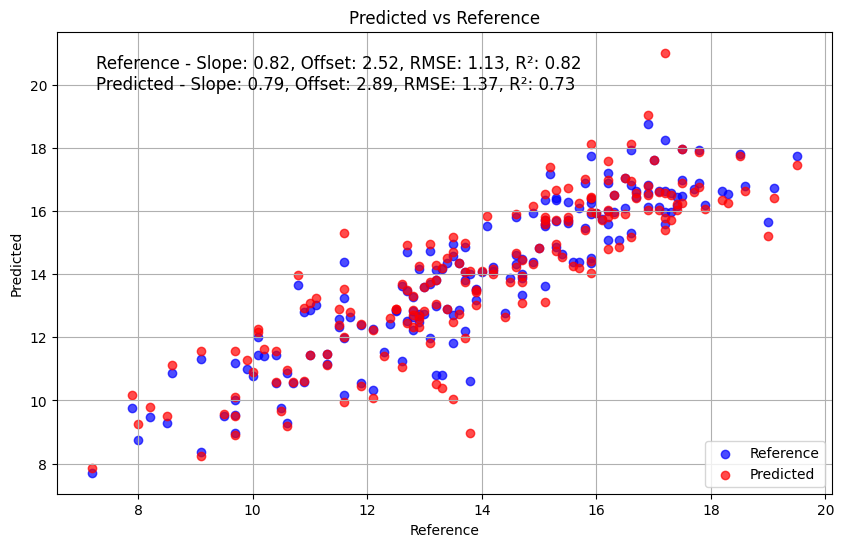

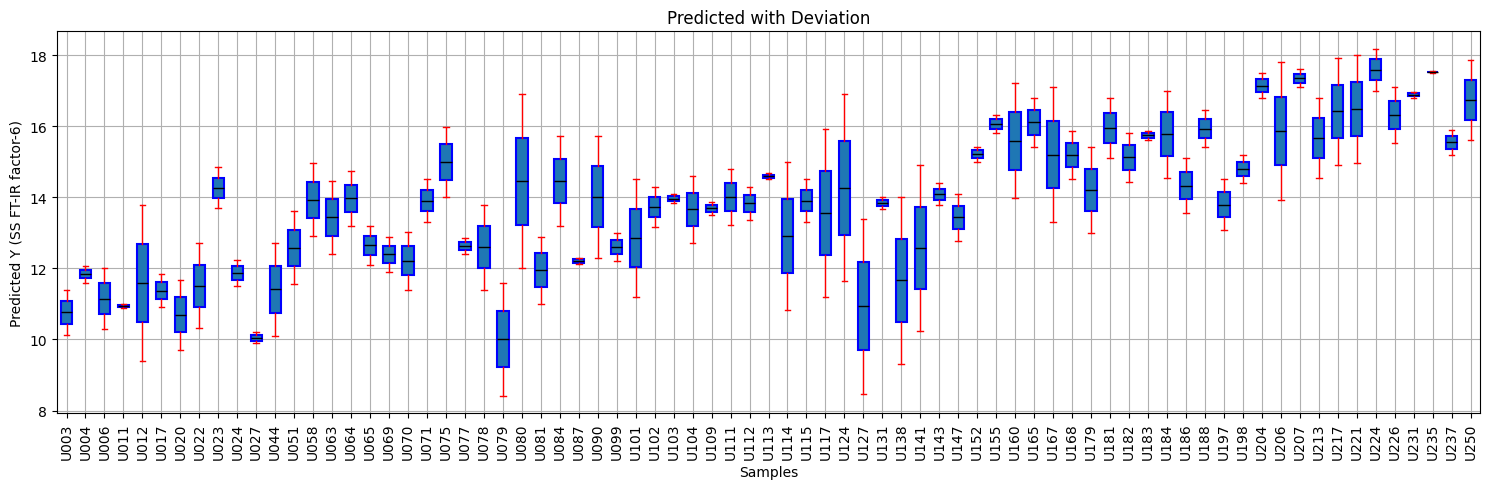

In [72]:
calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst = build_model(df_msc_cal, df_msc_cal['SST'], df_msc_val, df_msc_val['SST'])


Número de componentes: 8


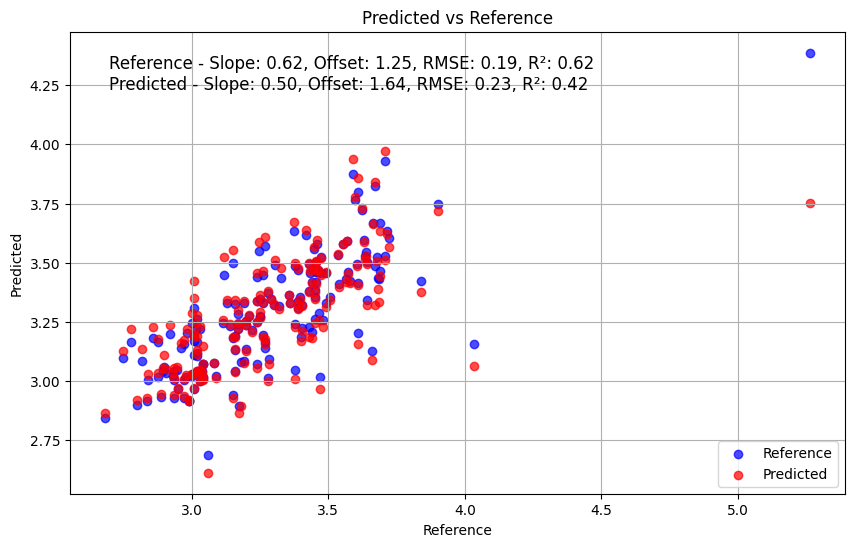

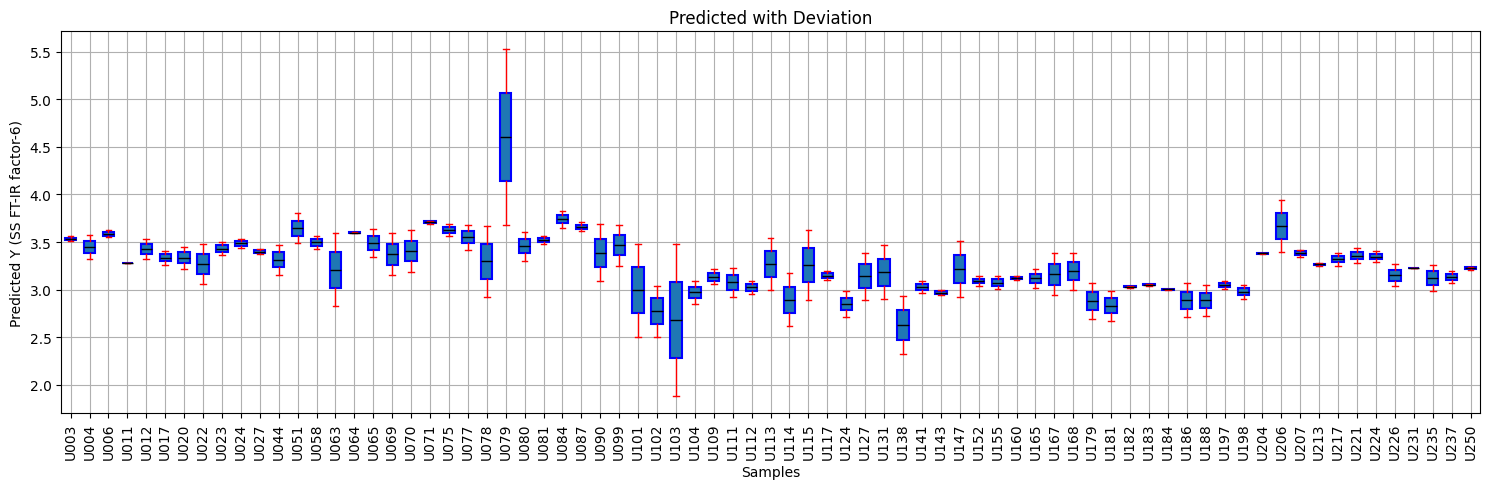

In [68]:
calibration_msc_ph, validation_msc_ph, Y_predict_msc_ph = build_model(df_msc_cal, df_msc_cal['PH'], df_msc_val, df_msc_val['PH'])

Número de componentes: 10


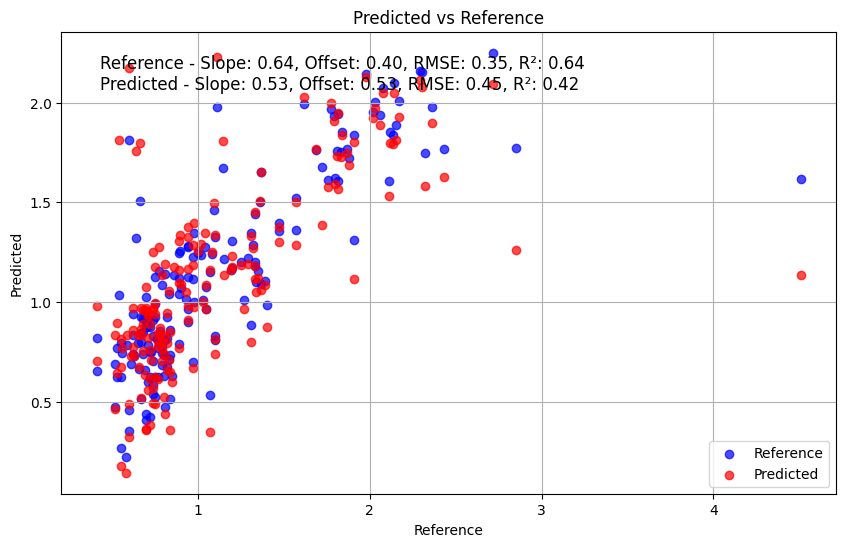

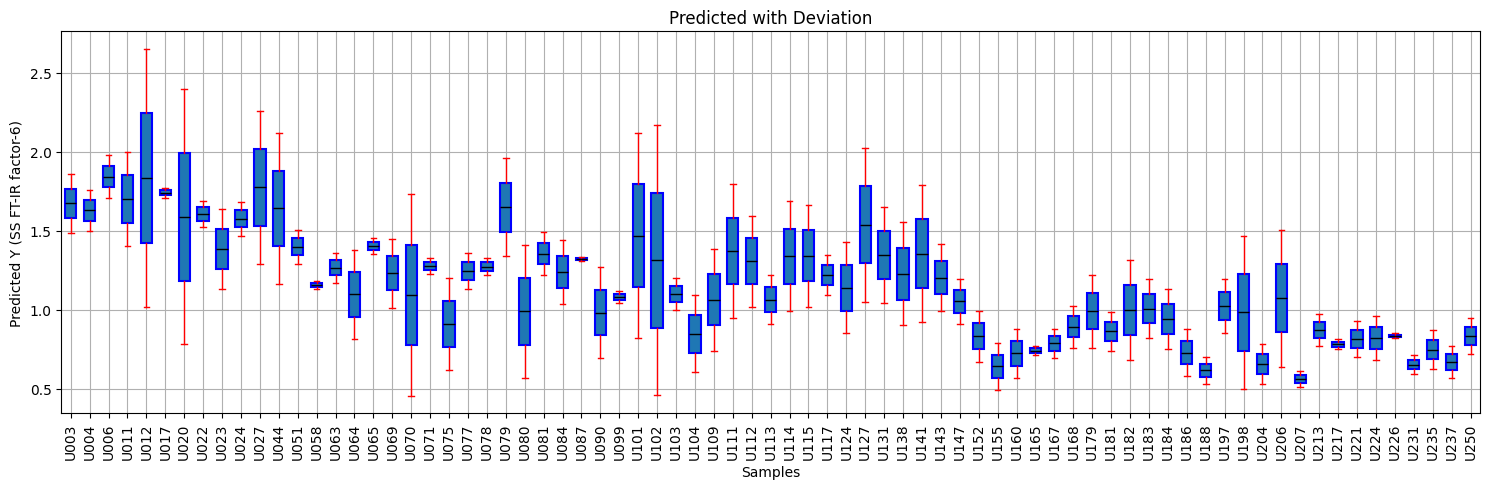

In [69]:
calibration_msc_at, validation_msc_at, Y_predict_msc_at = build_model(df_msc_cal, df_msc_cal['AT'], df_msc_val, df_msc_val['AT'])

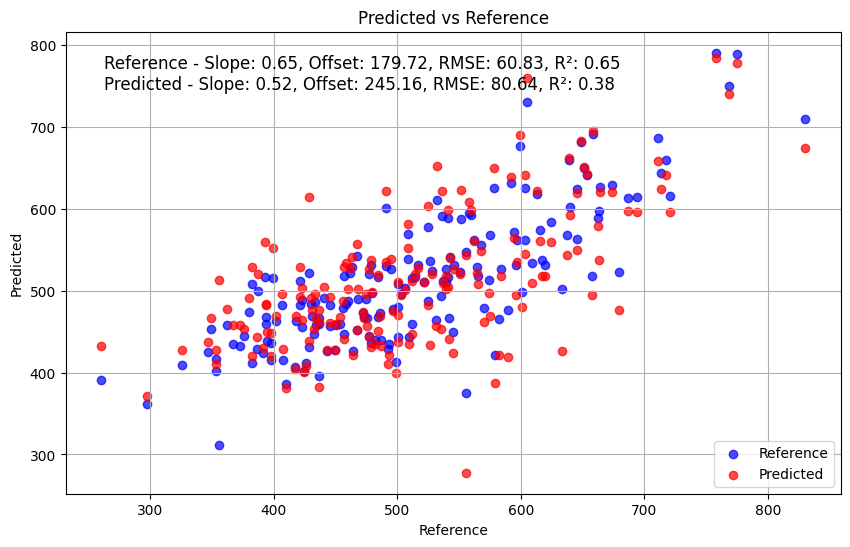

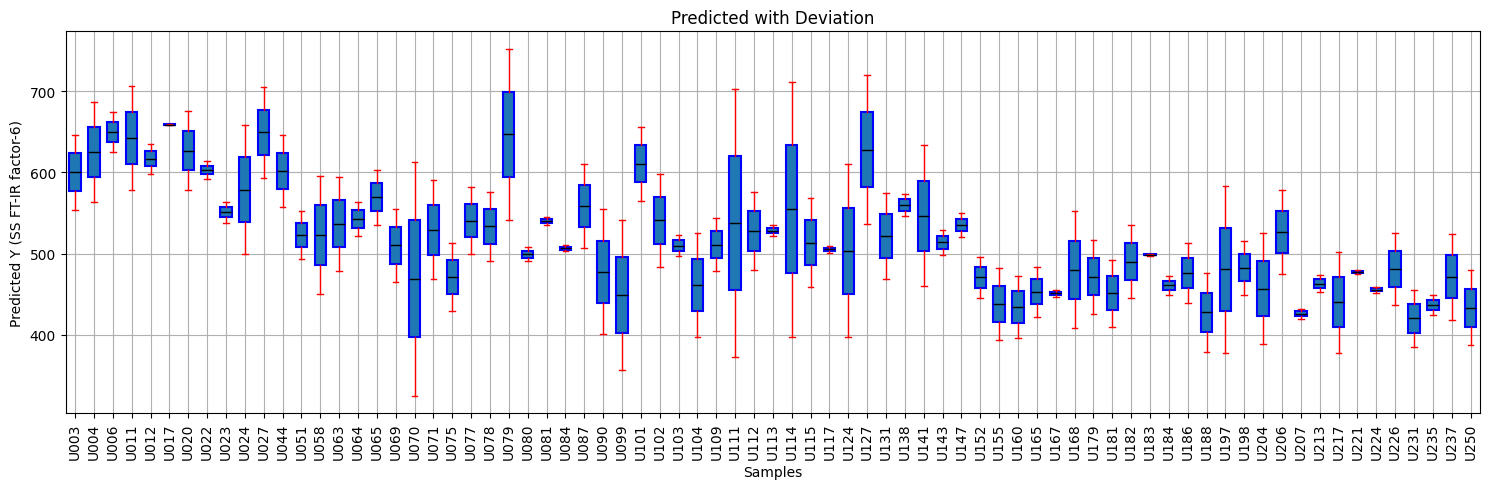

ValueError: not enough values to unpack (expected 4, got 3)

In [40]:
calibration_msc_f, validation_msc_f, Y_predict_msc_f = build_model(df_msc_cal, df_msc_cal['FIRMEZA (N)'], df_msc_val, df_msc_val['FIRMEZA (N)'])

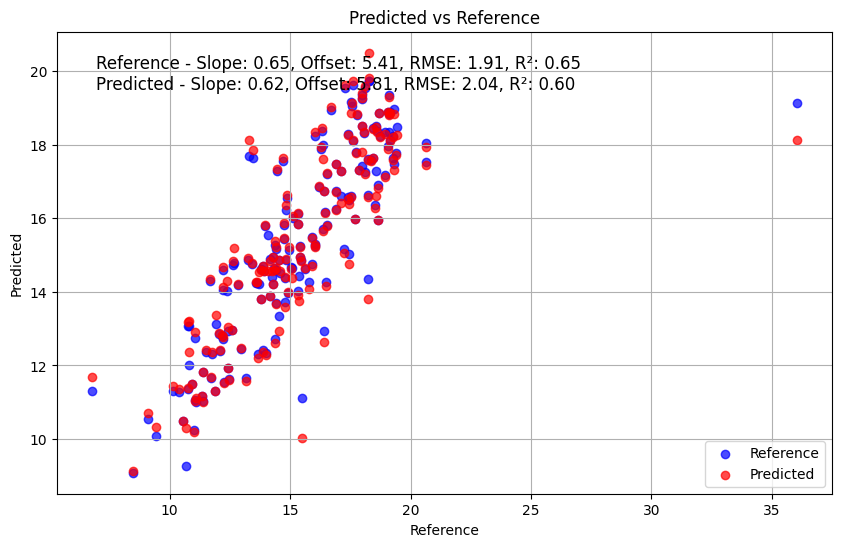

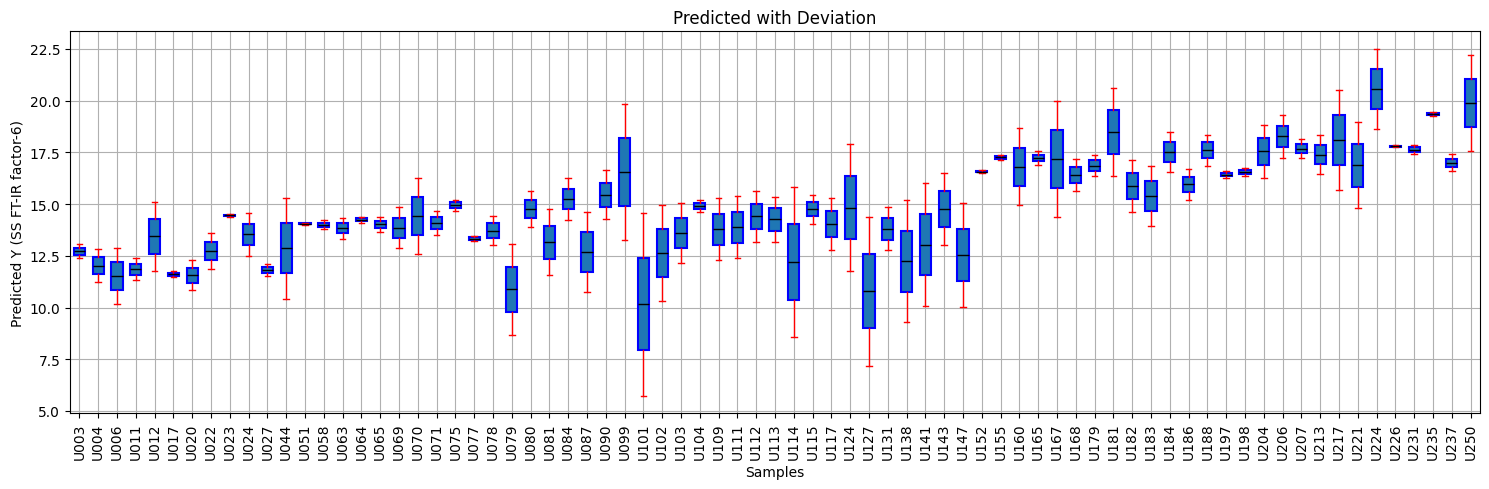

In [ ]:
calibration_msc_ubs, validation_msc_ubs, Y_predict_msc_ubs = build_model(df_msc_cal, df_msc_cal['UBS (%)'], df_msc_val, df_msc_val['UBS (%)'])

# Teste

In [83]:
def train_model(X_scaled, Y_scaled):
    max_lv = 10
    lvs = []
    k=1
    loo = LeaveOneOut()
    
    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pls_model = PLSRegression(n_components=lv, scale=False,max_iter=100)

        # Calibração do modelo
        pls_model.fit(X_scaled, Y_scaled)
        predictions_train = pls_model.predict(X_scaled)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        if Y_scaled.ndim == 1:
            Y_scaled = Y_scaled.reshape(-1, 1)
        if predictions_train.ndim == 1:
            predictions_train = predictions_train.reshape(-1, 1)

        correlation_cal = np.corrcoef(Y_scaled[:, 0], predictions_train[:, 0])[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train.flatten()

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(pls_model, X_scaled, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        if predictions_cv.ndim == 1:
            predictions_cv = predictions_cv.reshape(-1, 1)

        correlation_cv = np.corrcoef(Y_scaled[:, 0], predictions_cv[:, 0])[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv.flatten()
    
        mean_explained_variance = validation['r2_cv'].values
        
        min_index = 10
        
        for i in range(1, len(mean_explained_variance)):
            diff = mean_explained_variance[i] - mean_explained_variance[i - 1]
            decrease = mean_explained_variance[i] < mean_explained_variance[i - 1]
            if diff <= 0.009 or decrease:
                min_index = i  # Armazena o índice anterior
                break
        
        lv_num = min_index + 1
        
        pls_model = PLSRegression(n_components=lv_num)
        model = pls_model.fit(X_scaled, Y_scaled)

    
    return calibration, validation, lv_num, model, Y_values

def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, X_pred, y_pred, lv_number):
    X_centered, _, _, _ = center_data(X_pred.iloc[:,6:].values, y_pred.values)
    pred = model.predict(X_pred.iloc[:,6:].values)
       
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation', 'RMSEP'])
    
    prediction = pd.DataFrame(columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'bias_cv', 'secv_cv'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[0:,0].tolist()
    Y_predict['RMSEP'] = mean_squared_error(y_pred, pred)
    
    return prediction, Y_predict

def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()

def pred_plot(Y_predict):
    plt.figure(figsize=(15, 5))
    plt.title("Predicted with Deviation")

    # Plotar cada amostra
    for sample in Y_predict.index:
        y_pred = Y_predict.loc[sample, 'Y_pred']
        deviation = Y_predict.loc[sample, 'Deviation']
        y_true = Y_predict.loc[sample, 'Y_true']
        
        # Criar os dados do boxplot para esta amostra
        data_boxplot = [y_pred - deviation, y_pred, y_pred + deviation]
        
        # Plotar o boxplot
        plt.boxplot(data_boxplot, positions=[Y_predict.index.get_loc(sample)], widths=0.6, patch_artist=True, 
                    boxprops=dict(edgecolor='blue', linewidth=1.5),
                    whiskerprops=dict(color='red'),
                    capprops=dict(color='red'),
                    medianprops=dict(color='black'))
        
    plt.xticks(ticks=range(len(Y_predict.index)), labels=Y_predict['Amostra'], rotation=90)
    plt.xlabel('Samples')
    plt.ylabel('Predicted Y (SS FT-IR factor-6)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def build_model(X_cal, Y_cal, X_val, Y_val):
       
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    #abs_scaled, qua_scaled, m_abs, m_qua = center_data(X.iloc[:,6:].values, Y.values)
    calibration, validation, lv_num, model, Y_values = train_model(X.iloc[:,6:].values, Y.values)
    print(lv_num)
        
    prediction, Y_predict = predict(model, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_pred_vs_ref(Y_true, Y_pred, Y_opt)  
    pred_plot(Y_predict)
    
    return calibration, validation, Y_predict
    
    
    


In [102]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

def plsr(X, Y, n_components):
    # Converter X e Y para arrays NumPy de float
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float).reshape(-1, 1)
    # Inicialização
    T = []  # Scores
    P = []  # X loadings
    Q = []  # Y loadings
    W = []  # Weights
    U = []  # Y Scores
    E = X.copy()
    F = Y.copy()

    for _ in range(n_components):
        # 1. Calcular o vetor de peso w
        S = np.dot(E.T, F)
        eigvals, eigvecs = np.linalg.eig(np.dot(S, S.T))
        w = eigvecs[:, np.argmax(eigvals)]
        w = w.real  # Tomar apenas a parte real de w
        w = w / np.linalg.norm(w)  # Normalizar

        # 2. Calcular o score t
        t = np.dot(E, w)

        # 3. Calcular o loading p
        p = np.dot(E.T, t) / np.dot(t.T, t)

        # 4. Calcular o loading q
        q = np.dot(F.T, t) / np.dot(t.T, t)

        # 5. Calcular o score u
        u = np.dot(F, q) / np.dot(q.T, q)

        # 6. Armazenar T, P, Q, W, U
        T.append(t)
        P.append(p)
        Q.append(q)
        W.append(w)
        U.append(u)

        # 7. Atualizar E e F
        E = E - np.outer(t, p.T)
        F = F - np.outer(t, q.T)

    T = np.array(T).T
    P = np.array(P).T
    Q = np.array(Q).T
    W = np.array(W).T
    U = np.array(U).T

    # Calcular B (coeficientes de regressão)
    B = np.dot(np.dot(np.dot(W, np.linalg.inv(np.dot(T.T, T))), T.T), Y)

    return B, T, P, Q, W, U

def calculate_metrics(Y_true, Y_pred):
    
    Y_true = np.asarray(Y_true, dtype=float)
    Y_pred = np.asarray(Y_pred, dtype=float)
    
    # Certificar-se de que Y_true e Y_pred são 2D
    if Y_true.ndim == 1:
        Y_true = Y_true.reshape(-1, 1)
    if Y_pred.ndim == 1:
        Y_pred = Y_pred.reshape(-1, 1)
        
        
    r2 = r2_score(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    explained_variance = explained_variance_score(Y_true, Y_pred)
    correlation = np.corrcoef(Y_true[:, 0], Y_pred[:, 0])[0, 1]
    r2_pearson = correlation ** 2
    bias = np.mean(Y_pred - Y_true)
    
    return {
        "r2": r2,
        "rmse": rmse,
        "explained_variance": explained_variance,
        "correlation": correlation,
        "r2_pearson": r2_pearson,
        "bias": bias
    }


#calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst = build_model(df_msc_cal, df_msc_cal['SST'], df_msc_val, df_msc_val['SST'])

# Exemplo de uso
n_components = 10
X=df_msc_cal.iloc[:,6:].values
Y=df_msc_cal['SST'].values

B, T, P, Q, W, U = plsr(df_msc_cal.iloc[:,6:].values, df_msc_cal['SST'].values, n_components)

# Fazer previsões
Y_pred = np.dot(X, B)

# Calcular as métricas
metrics = calculate_metrics(Y, Y_pred)
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")


r2: 0.4129
rmse: 2.0354
explained_variance: 0.4167
correlation: 0.6721
r2_pearson: 0.4517
bias: -0.1634


In [103]:
# Dados de calibração
X = df_msc_cal.iloc[:, 6:].values
Y = df_msc_cal['SST'].values

max_lv = 10  # Número máximo de componentes
results = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'rmse_cal', 'explained_variance_cal', 'correlation_cal', 'r2_pearson_cal', 'bias_cal'])

for n_components in range(1, max_lv + 1):
    # Treine o modelo
    B, _, _, _, _, _ = plsr(X, Y, n_components)

    # Faça previsões
    Y_pred = np.dot(X, B)

    # Calcule as métricas
    metrics = calculate_metrics(Y, Y_pred)
    
    # Armazene os resultados
    results.loc[n_components, 'r2_cal'] = metrics['r2']
    results.loc[n_components, 'rmse_cal'] = metrics['rmse']
    results.loc[n_components, 'explained_variance_cal'] = metrics['explained_variance']
    results.loc[n_components, 'correlation_cal'] = metrics['correlation']
    results.loc[n_components, 'r2_pearson_cal'] = metrics['r2_pearson']
    results.loc[n_components, 'bias_cal'] = metrics['bias']

print(results)


      r2_cal  rmse_cal explained_variance_cal correlation_cal r2_pearson_cal  \
1   0.001835  2.653958               0.001835        0.489659       0.239765   
2   0.323039   2.18562               0.326847        0.571705       0.326847   
3   0.377961  2.095084               0.381746        0.627112        0.39327   
4   0.428977  2.007333               0.432764        0.696186       0.484675   
5   0.428431  2.008293               0.432217        0.695356       0.483521   
6   0.438868  1.989873               0.442653        0.712497       0.507652   
7   0.452716  1.965166               0.456501        0.737299        0.54361   
8   0.457436  1.956673               0.461221        0.746368       0.557065   
9   0.407961  2.043938               0.411747        0.665086        0.44234   
10  0.412915   2.03537                 0.4167         0.67205       0.451652   

    bias_cal  
1   0.000462  
2  -0.163926  
3  -0.163417  
4  -0.163471  
5  -0.163453  
6  -0.163444  
7  -0.163444  

In [104]:
# Exemplo de uso
n_components = 10
X=df_msc_cal.iloc[:,6:].values
Y=df_msc_cal['SST'].values
X, Y, _, _ = center_data(X, Y)

B, T, P, Q, W, U = plsr(df_msc_cal.iloc[:,6:].values, df_msc_cal['SST'].values, n_components)

# Fazer previsões
Y_pred = np.dot(X, B)

# Calcular as métricas
metrics = calculate_metrics(Y, Y_pred)
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

r2: 0.4167
rmse: 2.0288
explained_variance: 0.4167
correlation: 0.6721
r2_pearson: 0.4517
bias: 0.0000
